In [20]:
# std lib
from getpass import getpass
import warnings, os
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
from numpy.core.defchararray import startswith, count
from astropy import utils, io, convolution, stats
from astropy.visualization import make_lupton_rgb, simple_norm
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from photutils import find_peaks
from pyvo.dal import sia
import pylab as plt
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm
get_ipython().run_line_magic('matplotlib', 'inline')

# Local
import movies as mv

# Data Lab
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert

# plots default setup
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (8,8)
qc.set_profile('delve_private')

In [36]:
 #Pull data for NGC 5897, Age: 12.4 Gyr, [Fe/H] = -2.01 (Koch & Williams 2014)
NGC5897_coord = SkyCoord(ra = '15h17m24.40s', dec = '-21d00m36.4s', unit = (u.hourangle, u.deg))
ra = NGC5897_coord.ra.deg
dec = NGC5897_coord.dec.deg

# Create the query string; SQL keyword capitalized for clarity

query =f"""SELECT ra,dec,
mag_psf_g,mag_psf_r,mag_psf_i,
magerr_psf_g,magerr_psf_r,magerr_psf_i,
mag_auto_g,mag_auto_r,mag_auto_i,
magerr_auto_g,magerr_auto_r,magerr_auto_i,
extended_class_g,extended_class_r, extended_class_i,
spread_model_g, spread_model_r, spread_model_i,
spreaderr_model_g, spreaderr_model_r, spreaderr_model_i,
flags_g,flags_r,flags_i,
extinction_g,extinction_r,extinction_i
   FROM delve_y3t3.objects
   WHERE q3c_radial_query(ra, dec, {ra}, {dec}, 2.0) AND
         mag_auto_g BETWEEN 14 AND 25 AND
         (mag_auto_g - mag_auto_r) BETWEEN -0.4 AND 1.0"""


get_ipython().run_line_magic('time', '')
R = qc.query(sql=query,fmt='pandas') # R is a pandas DataFrame
tab = Table.from_pandas(R)
tab.write('tmp.fits',overwrite=True)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 22.9 µs


In [6]:
tab.write('tmp.fits',overwrite=True)

In [9]:
def angsep(lon1,lat1,lon2,lat2):
    """
    Angular separation (deg) between two sky coordinates.
    Borrowed from astropy (www.astropy.org)
    Notes
    -----
    The angular separation is calculated using the Vincenty formula [1],
    which is slighly more complex and computationally expensive than
    some alternatives, but is stable at at all distances, including the
    poles and antipodes.
    [1] http://en.wikipedia.org/wiki/Great-circle_distance
    """
    lon1,lat1 = np.radians([lon1,lat1])
    lon2,lat2 = np.radians([lon2,lat2])
    
    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.degrees(np.arctan2(np.hypot(num1,num2), denominator))

In [109]:
sep = angsep(ra,dec,tab['ra'],tab['dec'])
sel1 = (sep < 0.10); area1 = np.pi * 0.1**2
sel2 = (sep > 0.10) & (sep < 0.3); area2 = np.pi * (0.3**2 - 0.1**2)
sel3 = (sep > 0.3) & (sep < 0.5); area3 = np.pi * (0.5**2 - 0.3**2)
sel4 = (sep > 0.5) & (sep < 0.7); area4 = np.pi * (0.7**2 - 0.5**2)

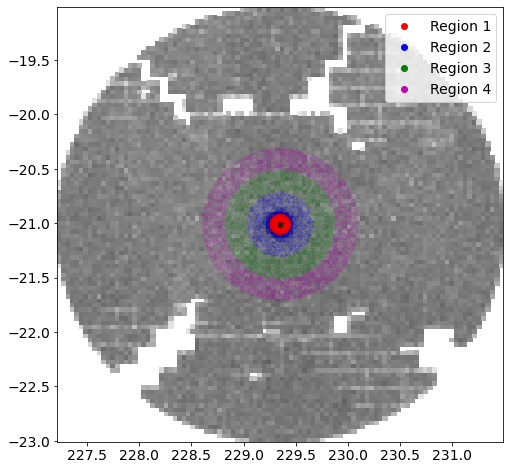

In [100]:
plt.figure()
plt.hist2d(tab['ra'],tab['dec'],bins=100,cmap='gray_r',norm=LogNorm())
plt.scatter(tab[sel1]['ra'],tab[sel1]['dec'],c='r',alpha=0.1,edgecolor='none',s=2); plt.plot(np.nan,np.nan,'ro',label='Region 1')
plt.scatter(tab[sel2]['ra'],tab[sel2]['dec'],c='b',alpha=0.1,edgecolor='none',s=2); plt.plot(np.nan,np.nan,'bo',label='Region 2')
plt.scatter(tab[sel3]['ra'],tab[sel3]['dec'],c='g',alpha=0.1,edgecolor='none',s=2); plt.plot(np.nan,np.nan,'go',label='Region 3')
plt.scatter(tab[sel4]['ra'],tab[sel4]['dec'],c='m',alpha=0.1,edgecolor='none',s=2); plt.plot(np.nan,np.nan,'mo',label='Region 4')
plt.legend()

(14.0, 24.0)

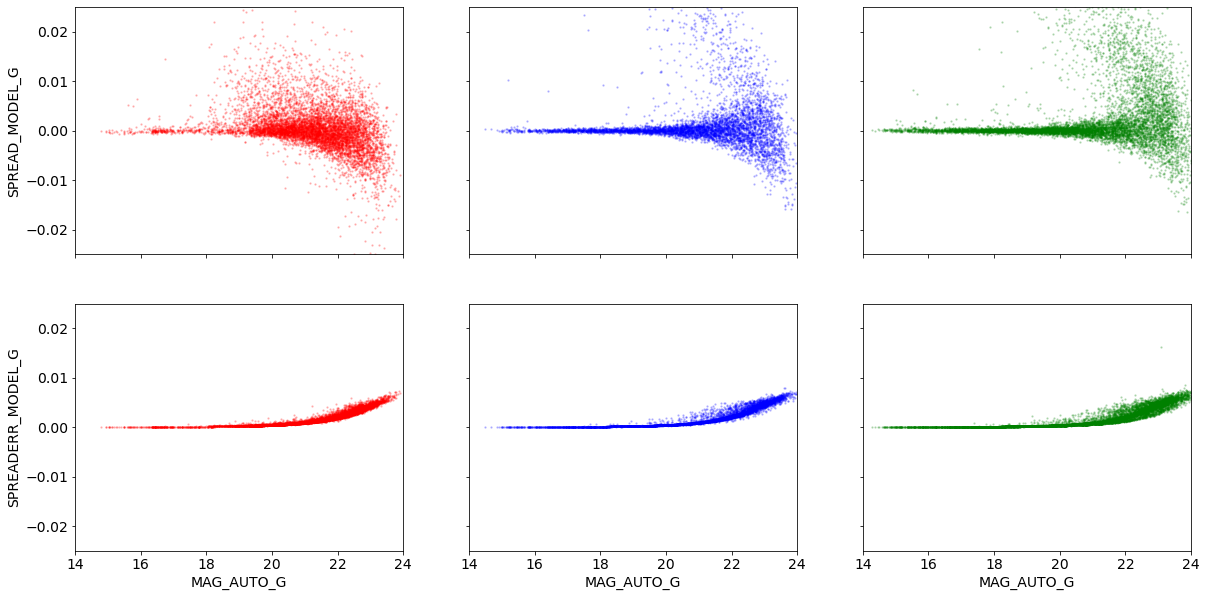

In [78]:
fig,axes = plt.subplots(2,3,figsize=(20,10),sharex=True,sharey=True)
kwargs=dict(alpha=0.2,s=2)
axes[0][0].scatter(tab[sel1]['mag_auto_g'],tab[sel1]['spread_model_g'],c='r',**kwargs)
axes[0][1].scatter(tab[sel2]['mag_auto_g'],tab[sel2]['spread_model_g'],c='b',**kwargs)
axes[0][2].scatter(tab[sel3]['mag_auto_g'],tab[sel3]['spread_model_g'],c='g',**kwargs)

axes[1][0].scatter(tab[sel1]['mag_auto_g'],tab[sel1]['spreaderr_model_g'],c='r',**kwargs)
axes[1][1].scatter(tab[sel2]['mag_auto_g'],tab[sel2]['spreaderr_model_g'],c='b',**kwargs)
axes[1][2].scatter(tab[sel3]['mag_auto_g'],tab[sel3]['spreaderr_model_g'],c='g',**kwargs)

axes[0][0].set_ylabel('SPREAD_MODEL_G')
axes[1][0].set_ylabel('SPREADERR_MODEL_G')
[axes[1][i].set_xlabel('MAG_AUTO_G') for i in range(3)]
                      
axes[0][0].set_ylim(-0.025,0.025)
axes[0][0].set_xlim(14,24)

(14.0, 24.0)

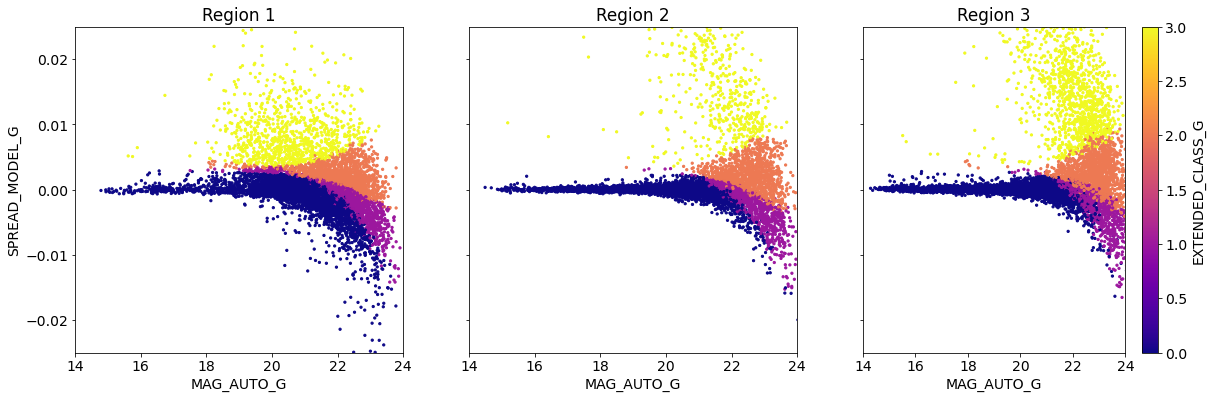

In [85]:
fig,axes = plt.subplots(1,3,figsize=(20,6),sharex=True,sharey=True)

kwargs=dict(s=5,cmap='plasma')
for i,sel in enumerate([sel1,sel2,sel3]):
    axes[i].set_title(f"Region {i+1}")
    im = axes[i].scatter(tab[sel]['mag_auto_g'],tab[sel]['spread_model_g'],c=tab[sel]['extended_class_g'],**kwargs)

plt.colorbar(im,label="EXTENDED_CLASS_G")
axes[0].set_ylabel('SPREAD_MODEL_G')
[axes[i].set_xlabel('MAG_AUTO_G') for i in range(3)]
                      
axes[0].set_ylim(-0.025,0.025)
axes[0].set_xlim(14,24)

In [92]:
def gc_extclass(spread_model,spreaderr_model):
    sel = np.abs(spread_model) < 0.002 + (3/5.)*spreaderr_model
    return sel

extclass = gc_extclass(tab['spread_model_g'],tab['spreaderr_model_g'])

(14.0, 24.0)

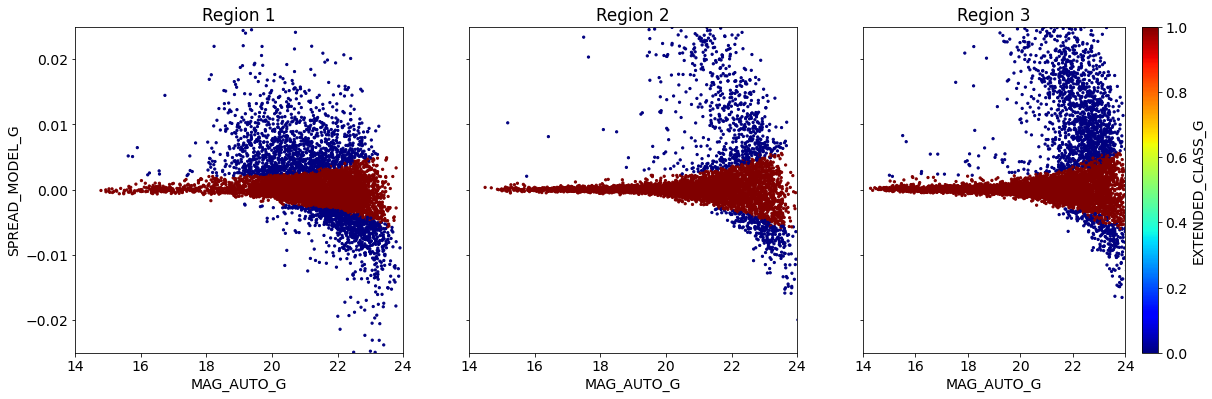

In [116]:
fig,axes = plt.subplots(1,3,figsize=(20,6),sharex=True,sharey=True)

kwargs=dict(s=5,cmap='jet')
for i,sel in enumerate([sel1,sel2,sel3]):
    axes[i].set_title(f"Region {i+1}")
    im = axes[i].scatter(tab[sel]['mag_auto_g'],tab[sel]['spread_model_g'],c=extclass[sel],**kwargs)

plt.colorbar(im,label="EXTENDED_CLASS_G")
axes[0].set_ylabel('SPREAD_MODEL_G')
[axes[i].set_xlabel('MAG_AUTO_G') for i in range(3)]
                      
axes[1].set_ylim(-0.025,0.025)
axes[1].set_xlim(14,24)

(14.0, 24.0)

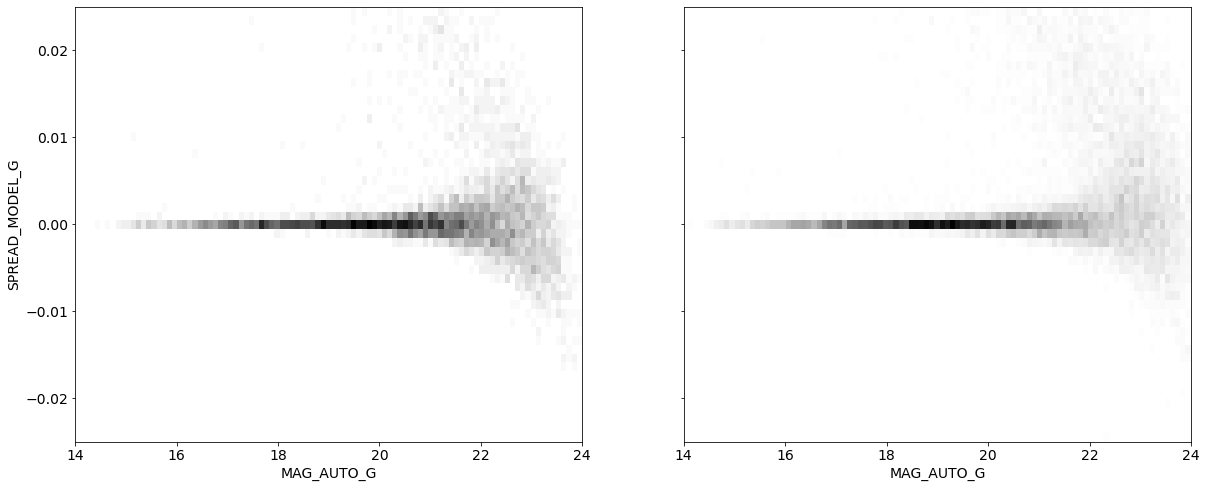

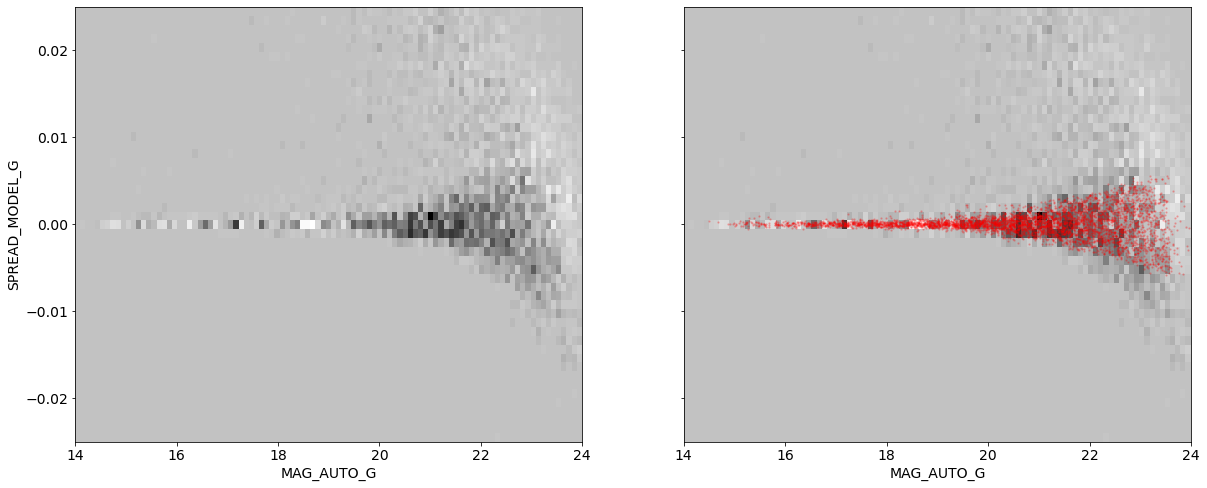

In [120]:
bins = [np.linspace(14,24,100),np.linspace(-0.025,0.025)]

sig,xbins,ybins = np.histogram2d(tab[sel2]['mag_auto_g'],tab[sel2]['spread_model_g'],bins=bins,weights=1/area2*np.ones(sel2.sum()))
bkg,xbins,ybins = np.histogram2d(tab[sel4]['mag_auto_g'],tab[sel4]['spread_model_g'],bins=bins,weights=1/area4*np.ones(sel4.sum()))

fig,axes = plt.subplots(1,2,figsize=(20,8),sharex=True,sharey=True)
axes[0].pcolormesh(xbins,ybins,sig.T,cmap='gray_r')
axes[1].pcolormesh(xbins,ybins,bkg.T,cmap='gray_r')
axes[0].set_ylabel('SPREAD_MODEL_G')
[axes[i].set_xlabel('MAG_AUTO_G') for i in range(2)]
                      
fig,axes = plt.subplots(1,2,figsize=(20,8),sharex=True,sharey=True)
axes[0].pcolormesh(xbins,ybins,(sig.T-bkg.T),cmap='gray_r')
axes[1].pcolormesh(xbins,ybins,(sig.T-bkg.T),cmap='gray_r')
axes[1].scatter(tab[sel2 & extclass==1]['mag_auto_g'],tab[sel2 & extclass==1]['spread_model_g'],c='r',s=2,alpha=0.2)
axes[0].set_ylabel('SPREAD_MODEL_G')
[axes[i].set_xlabel('MAG_AUTO_G') for i in range(2)]

axes[1].set_ylim(-0.025,0.025)
axes[1].set_xlim(14,24)